In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [5]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#from sklearn.impute import KNNImputer

In [7]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [8]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [9]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [10]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [11]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [12]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [13]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [14]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [15]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [16]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [17]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [18]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [19]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [20]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [21]:
train_df1 = train_df[train_df['vas_id']==1]
test_df1 = test_df[test_df['vas_id']==1]

In [22]:
train_df1.target.value_counts(normalize=True)

0.0    0.98174
1.0    0.01826
Name: target, dtype: float64

In [23]:
test_df1.target.value_counts(normalize=True)

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

In [24]:
train_df1.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
1,422578,1.0,1534107600,-96.799973,89.710884,-106.500786,49.823200,-111.918243,28.718210,-16.086180,...,0,0,8,225,33,1546203600,12096000,0,0,0.0
3,1186942,1.0,1537736400,411.670044,356.060883,397.729218,307.693207,392.311768,286.588196,-16.086180,...,0,0,9,267,39,1546203600,8467200,0,0,0.0
13,476011,1.0,1541970000,-96.799973,-170.889114,-110.740784,-223.496796,-116.158249,-244.601791,-16.086180,...,0,0,11,316,46,1546203600,4233600,0,0,0.0
15,2439189,1.0,1542574800,-96.799973,-48.009113,-76.840782,-32.816799,-82.258247,94.388214,-16.086180,...,0,0,11,323,47,1546203600,3628800,0,1,1.0
19,694672,1.0,1534712400,-96.799973,353.680878,-110.740784,301.073212,-116.158249,279.968201,-16.086180,...,0,0,8,232,34,1546203600,11491200,0,0,0.0
21,2639545,1.0,1534712400,-96.799973,-94.619110,-97.610786,-107.426796,-103.028244,-128.531784,-16.086180,...,0,0,8,232,34,1546203600,11491200,0,0,0.0
24,689772,1.0,1532293200,63.850029,342.960876,49.909214,292.473206,44.491753,271.368225,-16.086180,...,0,0,7,204,30,1546203600,13910400,0,0,0.0
34,3841819,1.0,1543179600,-87.649971,-124.599113,-97.350784,-168.726791,-102.768250,-189.831787,-16.086180,...,0,0,11,330,48,1546203600,3024000,0,0,0.0
37,2506064,1.0,1534712400,-96.799973,409.190887,96.879211,1187.063232,91.461754,1165.958252,-16.086180,...,0,0,8,232,34,1546203600,11491200,0,0,0.0
38,3990669,1.0,1531688400,69.290031,538.630859,62.109215,520.693176,56.691753,499.588196,145.763824,...,0,0,7,197,29,1546203600,14515200,0,0,0.0


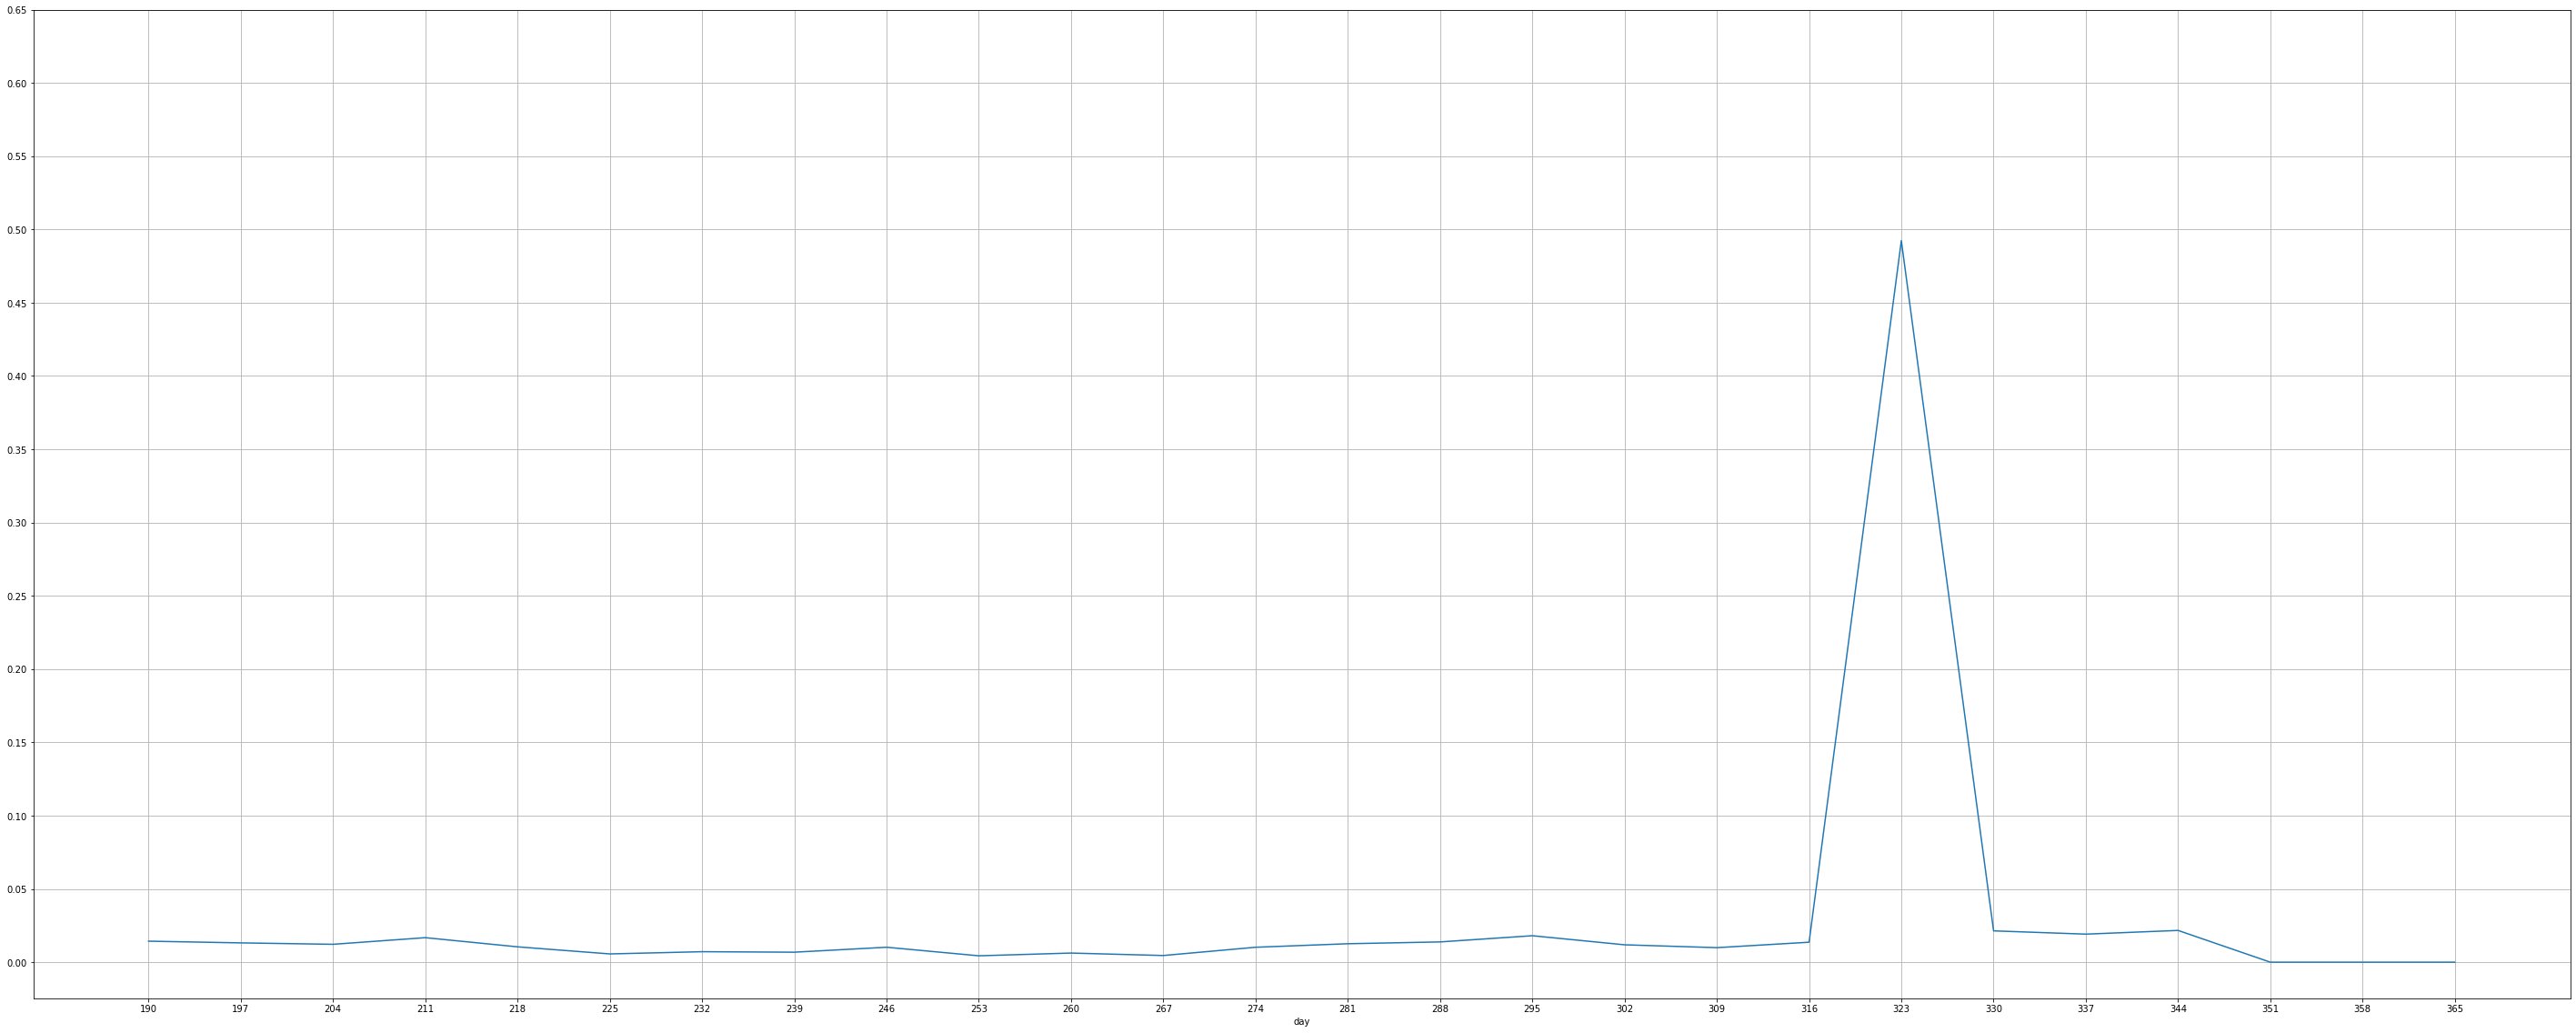

In [25]:
plt.figure(figsize=(50, 20))
train_df1.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df1['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 344 день.

# Разбиение на  train  и  test

In [26]:
TARGET_NAME = 'target'

In [27]:
X_train = train_df1.drop(columns=[TARGET_NAME])
y_train = train_df1[TARGET_NAME]
X_test = test_df1.drop(columns=[TARGET_NAME])
y_test = test_df1[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.98174
1.0    0.01826
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

In [28]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    182747
1.0    180147
Name: target, dtype: int64

In [29]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [30]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [31]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [32]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [33]:
list_spy.remove('vas_id')

In [34]:
#df_categorical = df_all[list_spy]

In [35]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [36]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [37]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [38]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [39]:
cat_feats = Categorical_features.columns.to_list()

In [40]:
cat_feats

[]

In [41]:
#df4[list_spy] = df4[list_spy].astype('object')

In [42]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [43]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [59]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

53.76493086201824

In [64]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.014432657773929

scale_pos_weight не помог

# XGBClassifier

In [44]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [45]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [46]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.98174
1.0    0.01826
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:15] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:04:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    182747
         1.0       0.97      0.57      0.72      3399

    accuracy                           0.99    186146
   macro avg       0.98      0.79      0.86    186146
weighted avg       0.99      0.99      0.99    186146

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    121764
         1.0       0.59      0.31      0.41      2265

    accuracy                           0.98    124029
   macro avg       0.79      0.65      0.70    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0  1.0
target             
0.0     121272  492
1.0       1559  706


macro avg       0.88      0.65      0.71     87015

In [47]:
#run_cv(model_xgb, kfold_cv, X_train, y_train, model_name="model_xgb");

model_xgb: f1_macro = 0.56 (+/- 0.00)


In [48]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [49]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:06:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    182747
         1.0       0.98      0.95      0.97    180147

    accuracy                           0.97    362894
   macro avg       0.97      0.97      0.97    362894
weighted avg       0.97      0.97      0.97    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.35      0.57      0.43      2265

    accuracy                           0.97    124029
   macro avg       0.67      0.77      0.71    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119361  2403
1.0        980  1285


macro avg       0.77      0.87      0.81     28204

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

In [50]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

model_xgb: f1_macro = 0.98 (+/- 0.00)



In [51]:
#show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

# LGBMClassifier

In [52]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [53]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.98174
1.0    0.01826
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    182747
         1.0       0.88      0.42      0.57      3399

    accuracy                           0.99    186146
   macro avg       0.94      0.71      0.78    186146
weighted avg       0.99      0.99      0.99    186146

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    121764
         1.0       0.63      0.28      0.39      2265

    accuracy                           0.98    124029
   macro avg       0.81      0.64      0.69    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0  1.0
target             
0.0     121399  365
1.0       1638  627


 macro avg       0.87      0.65      0.71     75129

In [54]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1 = 0.61 (+/- 0.01)

In [55]:
model_lgbm = LGBMClassifier(random_state=21)

In [56]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93    182747
         1.0       0.98      0.87      0.92    180147

    accuracy                           0.93    362894
   macro avg       0.93      0.93      0.93    362894
weighted avg       0.93      0.93      0.93    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.39      0.66      0.49      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.82      0.74    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119390  2374
1.0        776  1489


macro avg       0.78      0.87      0.82     28204

In [71]:
run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.93 (+/- 0.00)


In [58]:
#show_learning_curve_plot(model_lgbm, X_train_balanced, y_train_balanced)

# CatBoostClassifier

In [60]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [61]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [62]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.98174
1.0    0.01826
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    182747
         1.0       0.58      1.00      0.73      3399

    accuracy                           0.99    186146
   macro avg       0.79      0.99      0.86    186146
weighted avg       0.99      0.99      0.99    186146

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.42      0.62      0.50      2265

    accuracy                           0.98    124029
   macro avg       0.71      0.80      0.75    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119853  1911
1.0        866  1399


macro avg       0.76      0.83      0.79     75129

In [72]:
run_cv(model_catb, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.75 (+/- 0.02)


model_catb: f1_macro = 0.87 (+/- 0.01)


In [74]:
frozen_params2 = {
     #'class_weights':[1, disbalance2], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [75]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [76]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    182747
         1.0       0.99      1.00      0.99    180147

    accuracy                           0.99    362894
   macro avg       0.99      0.99      0.99    362894
weighted avg       0.99      0.99      0.99    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    121764
         1.0       0.43      0.58      0.50      2265

    accuracy                           0.98    124029
   macro avg       0.71      0.78      0.74    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     120056  1708
1.0        958  1307


macro avg       0.78      0.87      0.81     28204

In [73]:
run_cv(model_catb2, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_catb");

model_catb: f1_macro = 0.99 (+/- 0.00)


model_catb: f1_macro = 0.99 (+/- 0.00)





In [69]:
#show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

Можно бы было с CatBoostClassifier заморочиться, но для скорости выбираю LGBMClassifier на сбалансированных данных.

# Выбор метода балансировки датасета

In [77]:
df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [78]:
X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [79]:
model_lgbm_t = LGBMClassifier(random_state=21)

In [80]:
feature_importances = train_evaluate_preds(model_lgbm_t, X_train_tomek, X_test, y_train_tomek, y_test)

0.0    0.981591
1.0    0.018409
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    181236
         1.0       0.85      0.50      0.63      3399

    accuracy                           0.99    184635
   macro avg       0.92      0.75      0.81    184635
weighted avg       0.99      0.99      0.99    184635

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    121764
         1.0       0.58      0.38      0.46      2265

    accuracy                           0.98    124029
   macro avg       0.78      0.69      0.72    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0  1.0
target             
0.0     121140  624
1.0       1412  853


In [81]:
df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [82]:
X_train_smote= df_smote.drop(columns=TARGET_NAME)
y_train_smote = df_smote[TARGET_NAME]

In [83]:
model_lgbm_s = LGBMClassifier(random_state=21)

In [84]:
feature_importances = train_evaluate_preds(model_lgbm_s, X_train_smote, X_test, y_train_smote, y_test)

1.0    0.5
0.0    0.5
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    182747
         1.0       1.00      0.99      0.99    182747

    accuracy                           0.99    365494
   macro avg       0.99      0.99      0.99    365494
weighted avg       0.99      0.99      0.99    365494

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    121764
         1.0       0.55      0.36      0.43      2265

    accuracy                           0.98    124029
   macro avg       0.77      0.68      0.71    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0  1.0
target             
0.0     121083  681
1.0       1447  818


In [ ]:
#run_cv(model_catb_s, kfold_cv, X_train_smote, y_train_smote, model_name="model_catb");

In [ ]:
#fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote[fea_imp], X_test[fea_imp], y_train_smote, y_test)

In [ ]:
#X_train = X_train_smote[fea_imp]
#X_test = X_test[fea_imp]
#y_train = y_train_smote

# Удаление признаков

In [85]:
model_lgbm = LGBMClassifier(random_state=21)

In [86]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93    182747
         1.0       0.98      0.87      0.92    180147

    accuracy                           0.93    362894
   macro avg       0.93      0.93      0.93    362894
weighted avg       0.93      0.93      0.93    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.39      0.66      0.49      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.82      0.74    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119390  2374
1.0        776  1489


In [87]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [88]:
len(fea_imp)

203

In [89]:
X_train.shape

(186146, 272)

In [90]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced[fea_imp], X_test[fea_imp], y_train_balanced, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93    182747
         1.0       0.98      0.87      0.92    180147

    accuracy                           0.93    362894
   macro avg       0.93      0.93      0.93    362894
weighted avg       0.93      0.93      0.93    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.39      0.66      0.49      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.82      0.74    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119390  2374
1.0        776  1489


In [92]:
X_train = X_train_balanced[fea_imp]
X_test = X_test[fea_imp]
y_train = y_train_balanced

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [93]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [94]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [95]:
selector.ranking_

array([ 94,  95,   1,  67,   1,  59,   1,  60,   1,  62,   1,  51,   1,
         1,   1,  47,   1,   1,   1,   1,  46,   6,   1,   1,   1,  61,
         1,  83,   1,   1,   1,  33,   1,   1,   1,   9,  77,  80,  91,
         1,   1,  39,  27,   1,  49,  42,   1,  76,  10,   1,   1,   1,
         1,   1,   1,   1,   1,   7,   1,   1,   5,   2,  25,  11,  66,
        34,   1,  23,  24,  92,  69,   1,   1,  20,   1,   1,  22,   3,
        21,  35,   1,  17,   1,   1,  13,   1,   1,  90,  48,   1,   1,
         1,   1,   1,   1,   4,  16,  30,   1,   1,  75,   1,   1,   1,
         1,  40,   1,   1,   1,  43,  70,  12,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,  37,  38,  71,  58,
        36,   1,  18,  50,  32,   1,   1,   1,  28,   1,   8,  57,   1,
        26,   1,   1,   1,  72,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,  93,  96,  29,  68, 100,   1,  99,  98,  41,   1, 101,
        31, 103, 102,  14,  56,  82,  84,  44,  74,  64,  45,  8

In [96]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [97]:
X_test_short = X_test[last_col]

In [98]:
model_lgbm = LGBMClassifier(random_state=21)

In [99]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_short, X_test_short, y_train_balanced, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91    182747
         1.0       0.98      0.83      0.90    180147

    accuracy                           0.91    362894
   macro avg       0.92      0.90      0.90    362894
weighted avg       0.91      0.91      0.90    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.37      0.66      0.47      2265

    accuracy                           0.97    124029
   macro avg       0.68      0.82      0.73    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119200  2564
1.0        780  1485


In [21]:
model_lgbm = LGBMClassifier(random_state=21)

In [101]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93    182747
         1.0       0.98      0.87      0.92    180147

    accuracy                           0.93    362894
   macro avg       0.93      0.93      0.93    362894
weighted avg       0.93      0.93      0.93    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.39      0.66      0.49      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.82      0.74    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119390  2374
1.0        776  1489


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


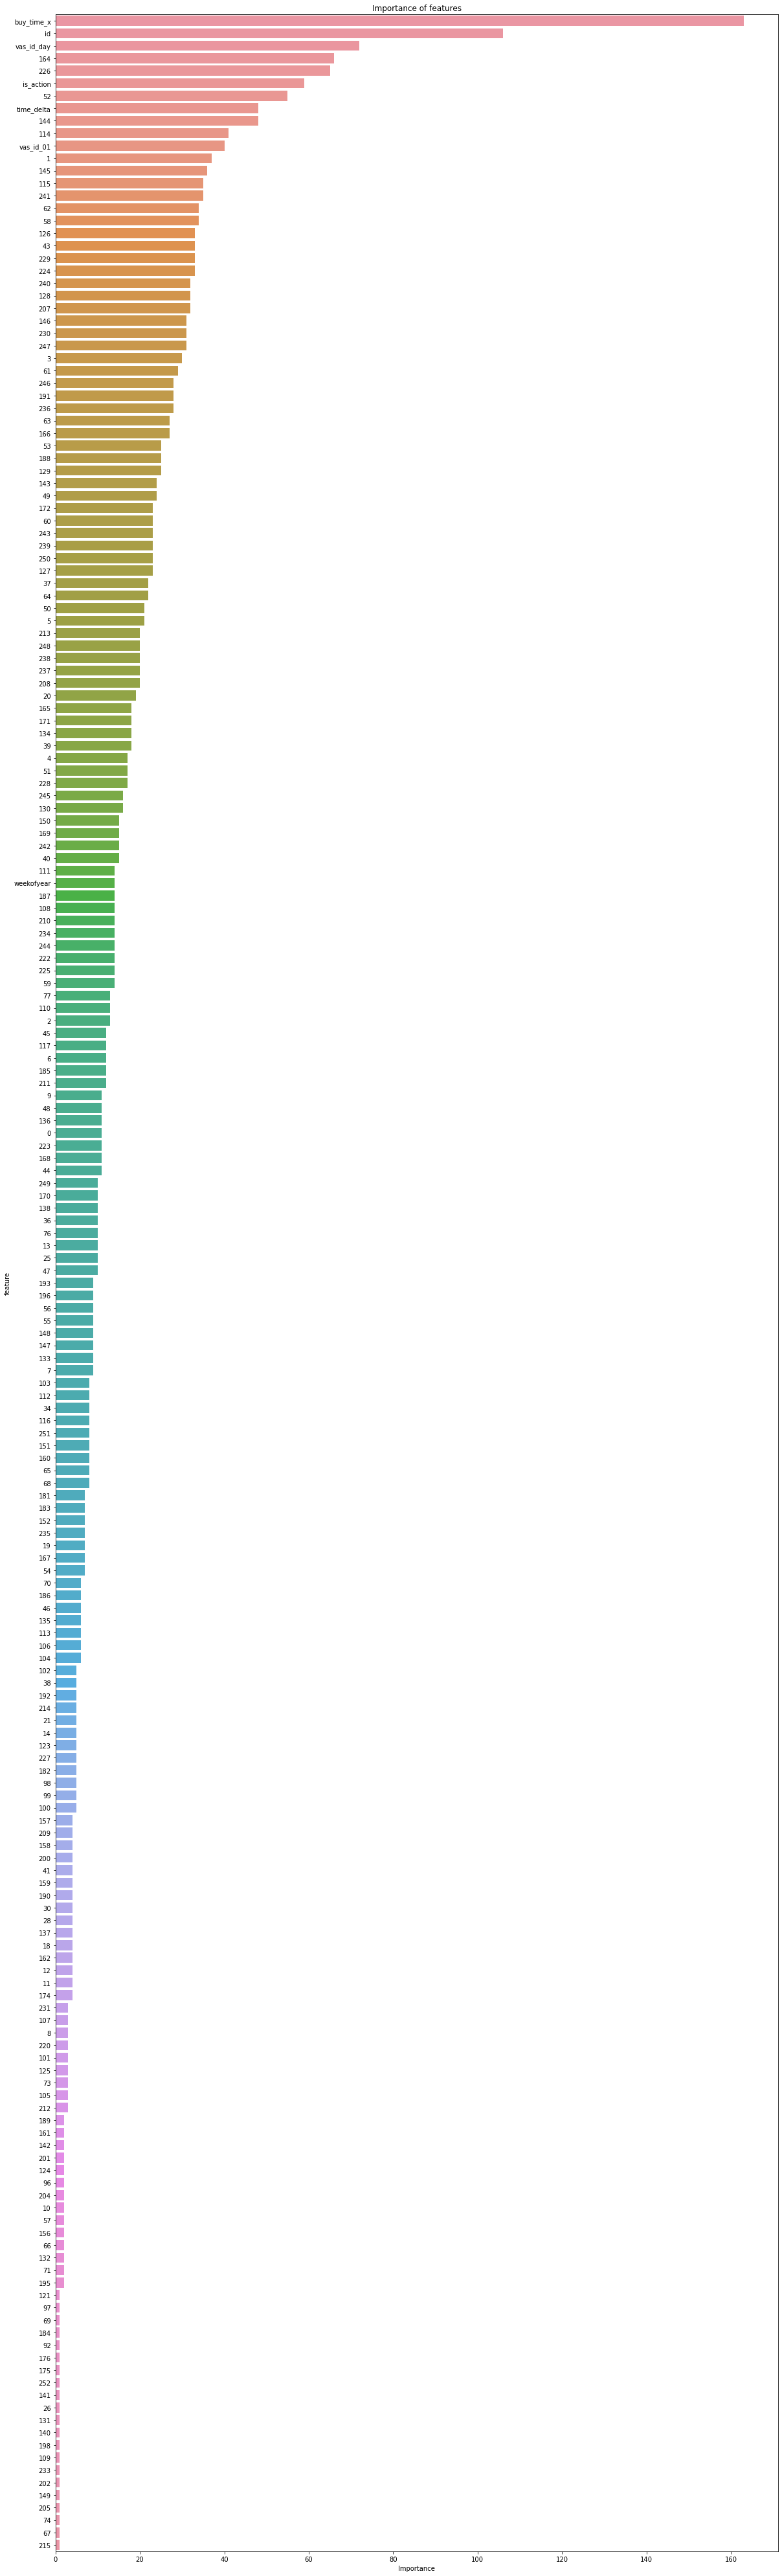

['buy_time_x', 'id', 'vas_id_day', '164', '226']

In [102]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [103]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [104]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


TypeError: list indices must be integers or slices, not tuple

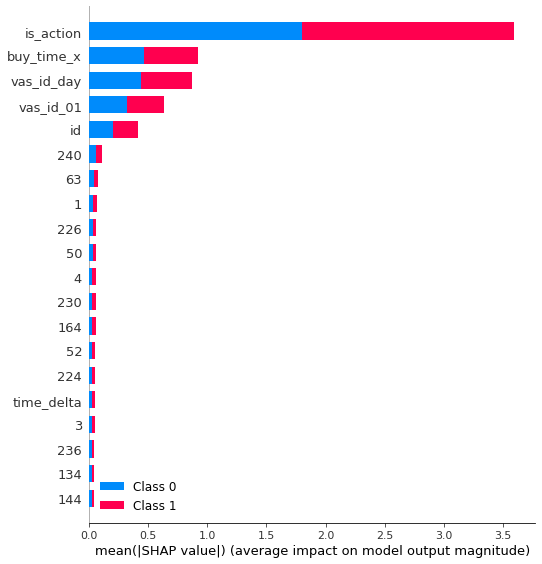

In [105]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


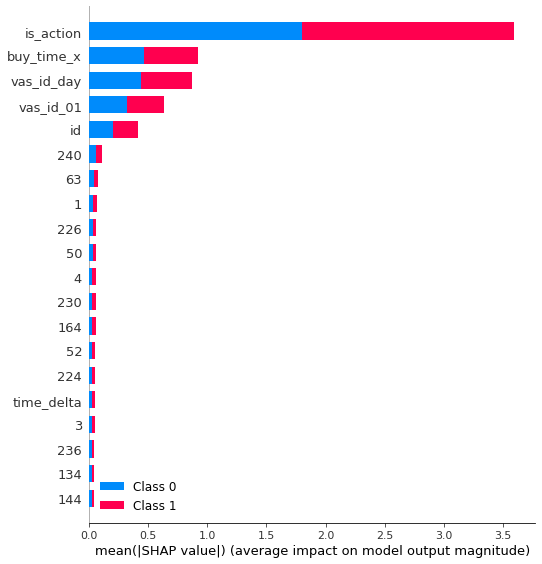

In [106]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [107]:
# Закладка
train_df1 = pd.concat([X_train, y_train], axis=1)
test_df1 = pd.concat([X_test, y_test], axis=1)
train_df1.to_csv('train_df1.csv', index=False)
test_df1.to_csv('test_df1.csv', index=False)

In [29]:
train_df1 = pd.read_csv('train_df1.csv')
test_df1 = pd.read_csv('test_df1.csv')
X_test = test_df1.drop(columns=['target'])
y_test = test_df1['target']
X_train = train_df1.drop(columns=['target'])
y_train = train_df1['target']

In [22]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93    182747
         1.0       0.98      0.87      0.92    180147

    accuracy                           0.93    362894
   macro avg       0.93      0.93      0.93    362894
weighted avg       0.93      0.93      0.93    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.39      0.66      0.49      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.82      0.74    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119390  2374
1.0        776  1489


# Подбор гиперпараметров

In [110]:
from matplotlib import pyplot

Исследование количества деревьев


In [111]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [50, 100, 200, 500, 1000, 1500]
    for n in trees:
        models[str(n)] = LGBMClassifier(random_state=21, n_estimators = n)
    return models

In [112]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [113]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.872 (0.004)
>100 0.928 (0.002)
>200 0.967 (0.001)
>500 0.991 (0.001)
>1000 0.995 (0.000)
>1500 0.996 (0.000)


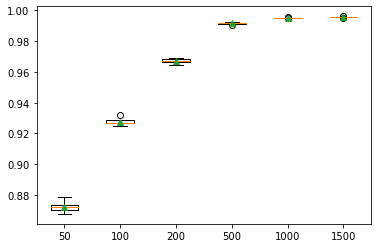

In [114]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование глубины дерева


In [115]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in [2, 4, 6, 8, 10]:
        models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i, random_state=21)
    return models

In [116]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [117]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>2 0.794 (0.002)
>4 0.817 (0.003)
>6 0.867 (0.002)
>8 0.931 (0.002)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


>10 0.975 (0.002)


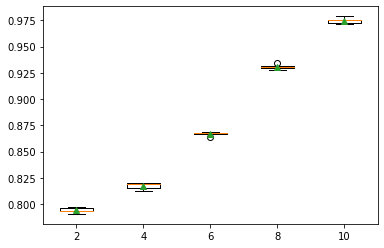

In [118]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование скорости обучения

In [119]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMClassifier(learning_rate=r, random_state=21)
    return models

In [120]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [121]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.781 (0.026)
>0.0010 0.803 (0.001)
>0.0100 0.811 (0.002)
>0.1000 0.928 (0.002)
>1.0000 0.977 (0.002)


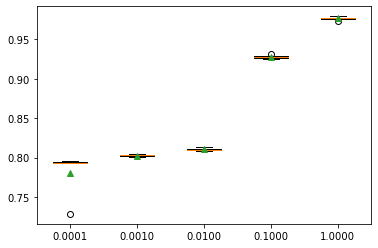

In [122]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование регуляризации

In [123]:
# get a list of models to evaluate
def get_models():
    models = dict()
    r_lambda = [0.01, 0.1, 1.0, 2, 4, 8]
    for r in r_lambda:
        key = '%.4f' % r
        models[key] = LGBMClassifier(reg_lambda=r, random_state=21)
    return models

In [124]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [125]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0100 0.927 (0.003)
>0.1000 0.927 (0.002)
>1.0000 0.926 (0.002)
>2.0000 0.928 (0.002)
>4.0000 0.928 (0.001)
>8.0000 0.928 (0.001)


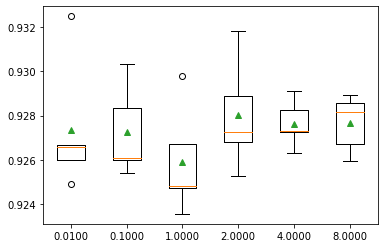

In [126]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [127]:
params = {'n_estimators':[100, 200],
          'max_depth':[8, 9, 10]}

In [128]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [129]:
model_lgbm = LGBMClassifier(random_state=21)

In [132]:
%%time

rs = GridSearchCV(model_lgbm, params, scoring='f1_macro', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 1min 27s, sys: 1.43 s, total: 1min 28s
Wall time: 7min 52s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=LGBMClassifier(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10], 'n_estimators': [100, 200]},
             scoring='f1_macro')

In [133]:
rs.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [134]:
rs.best_score_

0.9642387531573187

In [136]:
best_model = LGBMClassifier(random_state=21, max_depth = 10, n_estimators = 200)

In [137]:
best_model.fit(X_train, y_train)

LGBMClassifier(max_depth=10, n_estimators=200, random_state=21)

In [138]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    182747
         1.0       0.98      0.94      0.96    180147

    accuracy                           0.96    362894
   macro avg       0.96      0.96      0.96    362894
weighted avg       0.96      0.96      0.96    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.40      0.64      0.50      2265

    accuracy                           0.98    124029
   macro avg       0.70      0.81      0.74    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119630  2134
1.0        816  1449


метрику не подняло на тесте

In [144]:
model = LGBMClassifier(random_state=21, max_depth = 6)

In [145]:
feature_importances = train_evaluate_preds(model, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88    182747
         1.0       0.98      0.75      0.85    180147

    accuracy                           0.87    362894
   macro avg       0.89      0.87      0.87    362894
weighted avg       0.89      0.87      0.87    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.38      0.61      0.47      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.80      0.73    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119501  2263
1.0        873  1392


# Снижение степени переобучения

In [146]:
params = {'reg_lambda': [4, 6, 8],
         'learning_rate': [0.01, 0.1]
         }

In [147]:
model = LGBMClassifier(random_state=21)

In [149]:
%%time

rs = GridSearchCV(model, params, scoring='f1_macro', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 57.9 s, sys: 1.33 s, total: 59.3 s
Wall time: 6min 51s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=LGBMClassifier(random_state=21), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'reg_lambda': [4, 6, 8]},
             scoring='f1_macro')

In [150]:
rs.best_params_

{'learning_rate': 0.1, 'reg_lambda': 8}

In [151]:
best_model = LGBMClassifier(random_state=21, learning_rate = 0.1, reg_lambda = 8)

In [152]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93    182747
         1.0       0.98      0.87      0.92    180147

    accuracy                           0.93    362894
   macro avg       0.93      0.93      0.93    362894
weighted avg       0.93      0.93      0.93    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.38      0.66      0.48      2265

    accuracy                           0.97    124029
   macro avg       0.69      0.82      0.74    124029
weighted avg       0.98      0.97      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119370  2394
1.0        775  1490


In [163]:
model = LGBMClassifier(random_state=21, learning_rate = 0.0001)

In [164]:
feature_importances = train_evaluate_preds(model, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83    182747
         1.0       0.98      0.61      0.75    180147

    accuracy                           0.80    362894
   macro avg       0.85      0.80      0.79    362894
weighted avg       0.85      0.80      0.79    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.43      0.66      0.52      2265

    accuracy                           0.98    124029
   macro avg       0.71      0.82      0.75    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119789  1975
1.0        778  1487


# Штрафую нули

In [191]:
best_model = LGBMClassifier(class_weight = {0: 1, 1: 0.997}, random_state=21, learning_rate = 0.0001)

In [192]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.99      0.82    182747
         1.0       0.98      0.58      0.73    180147

    accuracy                           0.79    362894
   macro avg       0.84      0.78      0.78    362894
weighted avg       0.84      0.79      0.78    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    121764
         1.0       0.45      0.63      0.53      2265

    accuracy                           0.98    124029
   macro avg       0.72      0.81      0.76    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     120003  1761
1.0        828  1437


In [193]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.49 (+/- 0.43)


In [26]:
best_model = LGBMClassifier(random_state=21, learning_rate = 0.0001)

In [195]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.79 (+/- 0.02)


In [27]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.503582
1.0    0.496418
Name: target, dtype: float64

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83    182747
         1.0       0.98      0.61      0.75    180147

    accuracy                           0.80    362894
   macro avg       0.85      0.80      0.79    362894
weighted avg       0.85      0.80      0.79    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.43      0.66      0.52      2265

    accuracy                           0.98    124029
   macro avg       0.71      0.82      0.75    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119789  1975
1.0        778  1487


Не удалось оштрафовать :-)

# Подбор порога

In [199]:
#наши прогнозы для тестовой выборки
preds = best_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.49424974, 0.49449082, 0.49304678, 0.49304678, 0.49604361,
       0.49604361, 0.49304678, 0.49401623, 0.49420312, 0.50123944])

In [200]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.501082, F-Score=0.526, Precision=0.449, Recall=0.634


In [201]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [202]:
# Нашли метки предсказания для лучшего порога
best_predict = predict_proba_to_int(preds, thresholds[ix])

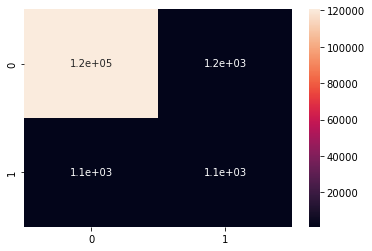

In [203]:
sns.heatmap(confusion_matrix(y_test, best_predict), annot=True)
plt.show()

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [204]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [205]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83    182747
         1.0       0.98      0.61      0.75    180147

    accuracy                           0.80    362894
   macro avg       0.85      0.80      0.79    362894
weighted avg       0.85      0.80      0.79    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.43      0.66      0.52      2265

    accuracy                           0.98    124029
   macro avg       0.71      0.82      0.75    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     119789  1975
1.0        778  1487


In [206]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83    182747
         1.0       0.98      0.61      0.75    180147

    accuracy                           0.80    362894
   macro avg       0.85      0.80      0.79    362894
weighted avg       0.85      0.80      0.79    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    121764
         1.0       0.49      0.49      0.49      2265

    accuracy                           0.98    124029
   macro avg       0.74      0.74      0.74    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0        0     1
target              
0.0     120583  1181
1.0       1146  1119
Best Threshold=0.501082


Не удалось повысить метрику.

Написал функцию для тонкой настройки трешхолда

In [24]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [28]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.5)

TRAIN

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83    182747
         1.0       0.98      0.61      0.75    180147

    accuracy                           0.80    362894
   macro avg       0.85      0.80      0.79    362894
weighted avg       0.85      0.80      0.79    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    121764
         1.0       0.43      0.66      0.52      2265

    accuracy                           0.98    124029
   macro avg       0.71      0.82      0.75    124029
weighted avg       0.98      0.98      0.98    124029

CONFUSION MATRIX

col_0        0     1
target              
0.0     119789  1975
1.0        778  1487


(array([0, 0, 1, ..., 1, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [30]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.495)

TRAIN

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82    182747
         1.0       0.84      0.76      0.80    180147

    accuracy                           0.81    362894
   macro avg       0.81      0.81      0.81    362894
weighted avg       0.81      0.81      0.81    362894

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    121764
         1.0       0.09      0.72      0.15      2265

    accuracy                           0.86    124029
   macro avg       0.54      0.79      0.54    124029
weighted avg       0.98      0.86      0.91    124029

CONFUSION MATRIX

col_0        0      1
target               
0.0     104497  17267
1.0        627   1638


(array([0, 1, 1, ..., 1, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]))

Модель очень чувствительна к трешхолду. С трешхолдом нет смысла возиться.

In [32]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [32]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[119789   1975]
 [   778   1487]]


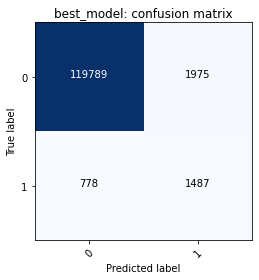

In [33]:
cm = confusion_matrix(y_test, y_test_poba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

# СОЗДАЮ ПАЙПЛАЙН

На сбалансированных данных! 


In [20]:
columns1 = ['id', 'buy_time_x', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
     '10', '11', '12', '13', '14', '18', '19', '20', '21', '25', '26', '28', '30',
     '34', '36', '37', '38', '39', '40', '41', '43', '44', '45', '46', '47', '48',
     '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61',
     '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '73', '74', '76',
     '77', '92', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105',
     '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116',
     '117', '121', '123', '124', '125', '126', '127', '128', '129', '130', '131',
     '132', '133', '134', '135', '136', '137', '138', '140', '141', '142', '143',
     '144', '145', '146', '147', '148', '149', '150', '151', '152', '156', '157',
     '158', '159', '160', '161', '162', '164', '165', '166', '167', '168', '169',
     '170', '171', '172', '174', '175', '176', '181', '182', '183', '184', '185',
     '186', '187', '188', '189', '190', '191', '192', '193', '195', '196', '198',
     '200', '201', '202', '204', '205', '207', '208', '209', '210', '211', '212',
     '213', '214', '215', '220', '222', '223', '224', '225', '226', '227', '228',
     '229', '230', '231', '233', '234', '235', '236', '237', '238', '239', '240',
     '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251',
     '252', 'time_delta', 'vas_id_01', 'weekofyear', 'vas_id_day', 'is_action']

In [21]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [22]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [23]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns1))
            ])

In [24]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', LGBMClassifier(random_state=21, learning_rate = 0.0001))
])

# Сохранение модели

In [6]:
import pickle

In [26]:
with open('model_1.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [27]:
with open('model_1.pkl', 'rb') as model:
    x = pickle.load(model)

In [30]:
x.fit(X_test, y_test)

Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['id', 'buy_time_x', '0',
                                                      '1', '2', '3', '4', '5',
                                                      '6', '7', '8', '9', '10',
                                                      '11', '12', '13', '14',
                                                      '18', '19', '20', '21',
                                                      '25', '26', '28', '30',
                                                      '34', '36', '37', '38',
                                                      '39', ...]))])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.0001, random_state=21))])

Confusion matrix, without normalization
[[121764      0]
 [  2265      0]]


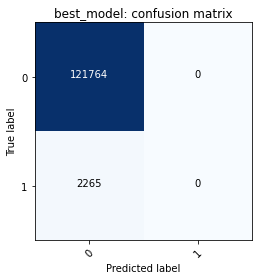

In [33]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

Матрица в пайплайне отличается от матрицы без пайплайна. Модель очень не устойчивая. Регулировать модель в пайплайне не буду.

In [4]:
best_model = LGBMClassifier(random_state=21, learning_rate = 0.0001)

In [7]:
with open('model1.pkl', 'wb') as model:
    pickle.dump(best_model, model)

In [8]:
with open('model1.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");